PythonでMIDIを解析する
===
---

## 1. MIDIファイルの構造

#### 参考
- http://maruyama.breadfish.jp/tech/smf/
- [スタンダードMIDIファイル - Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%82%BF%E3%83%B3%E3%83%80%E3%83%BC%E3%83%89MIDI%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB)

バイナリファイルを解析して楽譜の情報を取り出したい。

まずはPythonでMIDIファイルを開き、バイト列を2進数及び16進数の両方の形式で保持したPandas DataFrameに変換することにする。

### 1.1. チャンク
> SMFはチャンクと呼ばれるデータブロックから構成される。ファイルの先頭にあるチャンクはヘッダチャンク、それに続く演奏データが入るチャンクはトラックチャンクと呼ばれる。

いずれの場合も、最初の4byteがヘッダチャンク / トラックチャンクを区別する識別子・続く4byteがそのチャンクのデータ長となっている。
### 1.2. ヘッダチャンク
- `['4d', '54', '68', '64']`から始まり、楽曲の基本的な情報が含まれる。
- 具体的には、フォーマット(0, 1, 2)・トラック数・時間単位（四分音符あたりの分解能？）が含まれている。


### 1.3. トラックチャンク
- `['4d', '54', '72', '6b']`から始まり、実際の演奏データが含まれる。複数存在し得る。
- 9byte目以降がデータ本体で、デルタタイムとイベントの組が繰り返し現れることになる。
- デルタタイムは可変長の数値で表されており、最上位ビットが1なら次のバイトに続き、0ならそのバイトで完結している。最上位ビットを除く7ビット（を複数バイト分つなげたもの）で数値を表現している。

---
## 2. 実装
MIDIファイルへのパスで初期化すると内容を解析してくれるクラスを作る。

### 2.1. 準備

In [1]:
import pandas as pd
import os

### 2.2. 二進数の文字列を整数に変換する関数

In [2]:
def b2i(bin_str):
    """ 0と1の並んだ2進数のstrを正のintに変換 (ex. "0110" -> 6) """
    ret = 0
    for n, bit in enumerate(reversed(bin_str)):
        if not int(bit) in [0, 1]:
            return -1
        else:
            ret += int(bit) * (2**n)
    return ret

### 2.3. トラックチャンクのクラス

In [3]:
class Track:
    """ トラックチャンクを保持するクラス """
    
    def __init__(self, track_data):# track_data: トラックチャンクのDataFrame
        """ コンストラクタ """
        self.data = track_data
        self.events = pd.DataFrame(self.read_events(), columns = ["time", "status", "event_data"])
        self.notes = self.read_notes()
    
    def find_length(self, track_df):
        """
        与えられたtrack_dfの先頭から可変長数値を読み取り、
        可変長数値(int)と、track_dfから可変長数値のbyteを切り取ったものdfを返す
        """
        dt = ""
        num_byte = 0
        df = track_df.reset_index(drop=True)
        while True:
            flag = df["bin"][0][0]# 先頭byteの先頭bit
            dt = dt + df["bin"][0][1:]# 先頭byteの残りのbit
            df = df[1:].reset_index(drop=True)# 読み終えたbyteを切り取る
            if  flag == "0":
                break
        return b2i(dt), df
    
    
    def find_event(self, track_df, prev_status):
        """
        与えられたtrack_dfの先頭からイベントを1つ読み取り、イベントのステータスstatus、付加情報event_data
        ステータスバイト(次回以降のランニングステータス用)status_byte、
        tarck_dfから読み取ったイベント関連のbyteを切り取ったものdfを返す
        """
        df = track_df.reset_index(drop=True)
        
        if df["bin"][0][0] == "1":
            status_byte = df["hex"][0]
            running = 0 # ランニング・ステータスを適用しない
        else:
            # running status
            status_byte = prev_status # 直前のステータス（ランニング・ステータス時に用いる）
            running = 1 # ランニング・ステータスを適用
        
        event_data = {}
        
        if   status_byte[0] == "8":
            # note off
            status = "note_off"
            event_data["ch_num"] = status_byte[1]
            event_data["note_num"] = b2i(df["bin"][1-running])
            event_data["vel"] = b2i(df["bin"][2-running])
            df = df[3-running:].reset_index(drop=True)
        elif status_byte[0] == "9":
            # note on
            status = "note_on"
            event_data["ch_num"] = status_byte[1]
            event_data["note_num"] = b2i(df["bin"][1-running])
            event_data["vel"] = b2i(df["bin"][2-running])
            df = df[3-running:].reset_index(drop=True)
        elif status_byte[0] == "b":
            # control change
            status = "control_change"
            # データは利用しない
            df = df[3-running:].reset_index(drop=True)
            
        elif status_byte    == "f0":
            # sysex
            status = "sysex"
            # データは利用しない
            df = df[1:].reset_index(drop=True) # ステータスバイトを除く
            data_len, df = self.find_length(df)
            df = df[data_len:].reset_index(drop=True)
            print("SysEx exists!!!!!!!!!!")
        elif status_byte    == "f7":
            # sysex
            status = "sysex"
            # データは利用しない
            df = df[1:].reset_index(drop=True)
            data_len, df = self.find_length(df)
            df = df[data_len:].reset_index(drop=True)
            print("SysEx exists!!!!!!!!!!")
        elif status_byte    == "c0":
            # sound?
            status = "sound"
            df = df[2:].reset_index(drop=True)
            print("c0(sound?) exists!!!!!!!!!!")
        elif status_byte    == "ff":
            # meta event
            event_type = df["hex"][1]
            
            if   event_type == "00":
                status = "seq_num"
                assert df["hex"][2] == "02", "Sequence Number not starting from FF 00 02"
            elif event_type == "01":
                status = "text"
                
            elif event_type == "02":
                status = "copyright_notice"
                
            elif event_type == "03":
                status = "seq/track_name"
                
            elif event_type == "04":
                status = "instrument_name"
                
            elif event_type == "05":
                status = "lylic"
                
            elif event_type == "21":
                status = "port"
                
            elif event_type == "2f":
                status = "end_of_track"
                
            elif event_type == "51":
                status = "set_tempo"
                assert df["hex"][2] == "03", "Set Tempo not starting from FF 51 03"
                # 四分音符の長さ[usec]
                event_data["tempo"] = b2i("".join(df["bin"][3:6]))
            elif event_type == "58":
                status = "time_signature"
                assert df["hex"][2] == "04", "Time Signature not starting from FF 58 04"
                event_data["nn"] = df["hex"][3]
                event_data["dd"] = df["hex"][4]
                event_data["cc"] = df["hex"][5]
                event_data["bb"] = df["hex"][6]
            elif event_type == "59":
                status = "key_signature"
                assert df["hex"][2] == "02", "Key Signature not starting from FF 59 02"
                event_data["sf"] = df["hex"][3] # シャープ+1, フラット-1
                event_data["ml"] = df["hex"][4] # 0: 長調、1: 短調
            else:
                status = "unknown meta"
            df = df[2:].reset_index(drop=True)# ステータスバイトとイベントタイプを除く
            data_len, df = self.find_length(df)
            df = df[data_len:].reset_index(drop=True)
        else:
            status = "unknown"
            print("unknown event: status_byte={}".format(status_byte))
#            assert False, "Unknown Event"
        
        return status, event_data, status_byte, df
    
    
    def read_events(self):
        """ インスタンス変数として保持するデータからイベントのリストを生成する """
        # 初期化
        event_list = []
        current_time = 0
        status = ""
        status_byte = None
        cropped_data = self.data[8:].reset_index(drop=True) # チャンクタイプとデータ長を除いた本体
        
        while not status == "end_of_track":
            # 可変長数値のデルタタイムを読む
            dt, cropped_data = self.find_length(cropped_data)
            # イベントを読む
            status, event_data, status_byte, cropped_data = self.find_event(cropped_data, status_byte)
            # 現在の時刻
            current_time += dt
            # リストにイベントを追加
            #event_list.append({"time": current_time, "status": status, "event_data": event_data})
            event_list.append([current_time, status, event_data])
        return event_list
    
    def read_notes(self):
        """ インスタンス変数として保持するイベントのリストから、音符に関連する情報(status: note_on)だけ取り出す """
        note_ons = self.events[self.events.status == "note_on"]
        notes = pd.DataFrame()
        notes["time"] = note_ons["time"]
        notes["note_num"] = [e["note_num"] for e in note_ons["event_data"]]
        notes["vel"] = [e["vel"] for e in note_ons["event_data"]]
        return notes.reset_index(drop=True)

### 2.4. MIDIファイルの内容を保持するクラス

In [4]:
class Midi:
    """ MIDIファイルから得られるデータを保持するクラス """
    def __init__(self, midi_path):
        """ コンストラクタ：与えられたMIDIファイルのパスをもとにインスタンス変数を初期化 """
        self.data = self.open_midi(midi_path)
        self.header, self.tracks = self.split_data(self.data)
        self.format, self.track_num, self.time_unit = self.read_header(self.header)
        # pandasのindexを0からにリセット
        self.tracks = [track.reset_index(drop=True) for track in self.tracks]
        self.tracks = [Track(track) for track in self.tracks]
        
    def header_info(self):
        return "Format = {0}, Number of track = {1}, Units per beat = {2}".format(self.format, self.track_num, self.time_unit)
        
    def open_midi(self, path):
        """ 与えられたmidiファイルを開き、2進数・16進数の並んだデータを返す """
        with open(path, 'rb') as f:
            raw_data = f.read()
        data = pd.DataFrame()
        data["bin"] = ["{:08b}".format(d) for d in raw_data]
        data["hex"] = ["{:02x}".format(d) for d in raw_data]
        return data
    
    def split_data(self, data):
        """ データをチャンクに分割 """
        tracks = []
        while not data.empty:
            assert (list(data["hex"][:4]) in [['4d', '54', '68', '64'], ['4d', '54', '72', '6b']]), "chunk is not header/track"
        
            chunk_len = b2i("".join(data[4:8]["bin"])) # この後チャンクが何byte続くか
            chunk = data[0:8+chunk_len] # 8: チャンクタイプ4byte+データ長4byte
        
            if   list(data["hex"][:4]) == ['4d', '54', '68', '64']: # header：1つのみ
                header = chunk
            elif list(data["hex"][:4]) ==  ['4d', '54', '72', '6b']: # track：複数あり得る
                tracks.append(chunk)
                
            data = data[8+chunk_len:]
        return header, tracks
    
    def read_header(self, header):
        """ ヘッダから情報を取り出す """
        f  = b2i("".join(header["bin"][8:10])) # format
        tn = b2i("".join(header["bin"][10:12]))# track number
        assert header["bin"][12][0] == "0", "division byte starts from bit 1"# 普通は最初のbitが0のはず
        # units per beat：1拍子あたりの分解能? 
        upb = b2i("".join(header["bin"][12:14]))

        return f, tn, upb

---
## 3. MIDIファイルを実際に解析する

In [9]:
midi_path.split("/")[-1].split(".")[0]

'14canons'

In [22]:
def num_to_name(note_num):
    """ ノートNo. (21 - 108)を音名に変換 """
    names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    return names[note_num % 12]

In [28]:
df["note_num"]

0      17
1      17
2      19
3      19
4      19
5      19
6      21
7      21
8      22
9      22
10     22
11     22
12     22
13     22
14     22
15     22
16     24
17     24
18     24
19     24
20     24
21     24
22     24
23     24
24     24
25     24
26     26
27     26
28     26
29     26
       ..
838    58
839    58
840    58
841    58
842    60
843    60
844    60
845    60
846    60
847    60
848    60
849    60
850    60
851    60
852    60
853    60
854    60
855    60
856    60
857    60
858    60
859    60
860    60
861    60
862    60
863    60
864    62
865    62
866    62
867    62
Name: note_num, Length: 868, dtype: int64

In [29]:
midi_path = "../midi_data/aria.mid"
midi = Midi(midi_path)
print(midi.header_info())

num_keys = 88 # 88 key
offset = 21 # MIDI note number -> index for 88 key

for track_id, track in enumerate(midi.tracks):
    print("Track No. {}".format(track_id))
    notes = [[] for _ in range(num_keys)]
    
    for _, row in midi.tracks[0].notes.iterrows():
        if row["vel"] > 0:  # note on
            notes[row["note_num"]-offset].append([row["time"]])
        else:  # note off
            notes[row["note_num"]-offset][-1].append(row["time"])
    
    note_list = []
    for note_num, l in enumerate(notes):
        for n in l:
            note_list.append([note_num, n[0], n[1], num_to_name(note_num)])
    df = pd.DataFrame(note_list, columns=["note_num", "start", "end", "name"])
    df["end"] = df["end"]+1
    
    df["start"] = 1.0 * df["start"] / midi.time_unit
    df["end"] = 1.0 * df["end"] / midi.time_unit
    
    df.to_csv("../visualization/csv/{0}_{1}.csv".format(midi_path.split("/")[-1].split(".")[0], track_id), index=False)

Format = 1, Number of track = 2, Units per beat = 480
Track No. 0
Track No. 1


In [30]:
df

,note_num,start,end,name
0,17,129.000,129.500000,F
1,17,177.000,177.500000,F
2,19,118.000,118.500000,G
3,19,128.500,129.000000,G
4,19,166.000,166.500000,G
5,19,176.500,177.000000,G
6,21,128.000,128.500000,A
7,21,176.000,176.500000,A
8,22,21.000,22.500000,A#
9,22,69.000,70.500000,A#


In [101]:
midi.tracks[0].notes.head()

,time,note_num,vel
0,0,55,80
1,479,55,0
2,480,54,80
3,959,54,0
4,960,52,80


In [102]:
num_keys = 88 # 88 key
offset = 21 # MIDI note number -> index for 88 key
notes = [[] for _ in range(num_keys)]

In [103]:
for _, row in midi.tracks[0].notes.iterrows():
    if row["vel"] > 0:  # note on
        notes[row["note_num"]-offset].append([row["time"]])
    else:  # note off
        notes[row["note_num"]-offset][-1].append(row["time"])

In [104]:
for n in notes[22]:
    print({"note_num": 22, "start": n[0], "end": n[1]})

{'note_num': 22, 'start': 3360, 'end': 3839}
{'note_num': 22, 'start': 3840, 'end': 4319}
{'note_num': 22, 'start': 7680, 'end': 8159}
{'note_num': 22, 'start': 11520, 'end': 11999}
{'note_num': 22, 'start': 47520, 'end': 47999}
{'note_num': 22, 'start': 51360, 'end': 51839}
{'note_num': 22, 'start': 55200, 'end': 55679}


In [112]:
note_list = []

In [113]:
for note_num, l in enumerate(notes):
    for n in l:
        note_list.append([note_num, n[0], n[1]])
        #note_list.append({"note_num": note_num, "start": n[0], "end": n[1]})

In [128]:
df = pd.DataFrame(note_list, columns=["note_num", "start", "end"])

In [129]:
df["end"] = df["end"]+1
df

,note_num,start,end
0,22,3360,3840
1,22,3840,4320
2,22,7680,8160
3,22,11520,12000
4,22,47520,48000
5,22,51360,51840
6,22,55200,55680
7,26,1920,2400
8,26,5280,5760
9,26,9120,9600


In [144]:
midi.time_unit

480

In [145]:
df["start"] = 1.0 * df["start"] / midi.time_unit
df["end"] = 1.0 * df["end"] / midi.time_unit

In [147]:
df.to_csv("../note_data/14canons_0.csv", index=False)

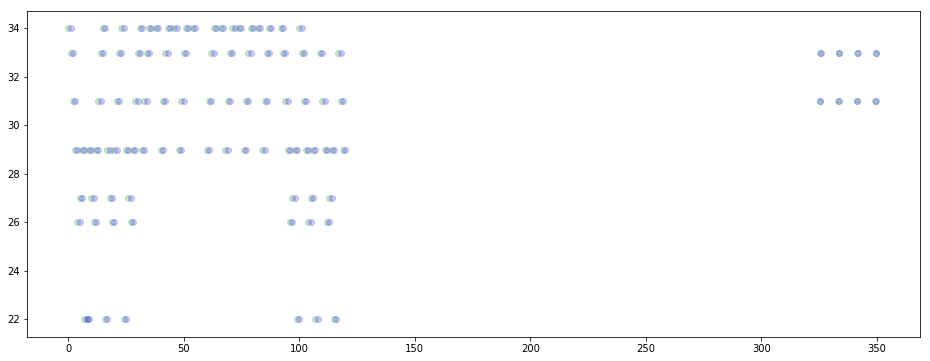

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 6))
plt.scatter(df["start"][:100], df["note_num"][:100], color="green", alpha=0.2)
plt.scatter(df["end"][:100], df["note_num"][:100], color="blue", alpha=0.2)